In [1]:
!pip install tensorflow==2.2.0
!pip install keras==2.3.1

     |████████████████████████████████| 516.2MB 22kB/s 
     |████████████████████████████████| 460kB 50.2MB/s 
     |████████████████████████████████| 3.0MB 56.2MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 378kB 2.1MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


# Segmentation of Indian Traffic

In [2]:
!pip install PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ"})
downloaded.GetContentFile('data.zip')

In [6]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

In [7]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [8]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    
    image = list()
    json = list()
    
    scenes = os.listdir(os.path.join(root_dir,'images'))
    
    for scene in scenes:
        
        if scene == '.DS_Store':
            continue
        
        image_frames = os.listdir(os.path.join(root_dir,'images',scene))
        image_frames.sort()
        image_frames = [ str(os.path.join(root_dir,'images',scene,i)) for i in image_frames]
        
        mask_frames = os.listdir(os.path.join(root_dir,'mask',scene))
        mask_frames.sort()
        mask_frames = [ str(os.path.join(root_dir,'mask',scene,i)) for i in mask_frames]
        
        image.extend(image_frames)
        json.extend(mask_frames)
    
    data_df = pd.DataFrame(list(zip(image, json)), columns =['image', 'json'])
    
    return data_df

In [9]:
root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/224/frame1127_leftImg8bit.jpg,data/mask/224/frame1127_gtFine_polygons.json
1,data/images/224/frame1365_leftImg8bit.jpg,data/mask/224/frame1365_gtFine_polygons.json
2,data/images/224/frame1796_leftImg8bit.jpg,data/mask/224/frame1796_gtFine_polygons.json
3,data/images/224/frame2227_leftImg8bit.jpg,data/mask/224/frame2227_gtFine_polygons.json
4,data/images/224/frame2452_leftImg8bit.jpg,data/mask/224/frame2452_gtFine_polygons.json


In [10]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [11]:
grader_1(data_df)

True

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">



* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [12]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    
    json_path = data_df['json']
    
    unique_labels =list([])
    
    for path in json_path:
        with open(path) as f:
            data = json.load(f)
            for obj in data['objects']:
                unique_labels.append(obj['label'])
           
    return unique_labels

In [13]:
unique_labels = return_unique_labels(data_df)

In [14]:
unique_labels = set(unique_labels)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [15]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [16]:
len(set(label_clr.values()))

21

In [17]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [18]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    
    
    with open(file, 'r') as f:
        data = json.load(f)
    h = data['imgHeight']
    w = data['imgWidth']
    
    label = list([])
    vertexlist = list([])
    
    for obj in data['objects']:
        curr_vertices = list([])
        label.append(obj['label'])
        for vertex in obj['polygon']:
            curr_vertices.append((vertex[0], vertex[1]))
        vertexlist.append(curr_vertices)
        
    return w, h, label, vertexlist


In [19]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

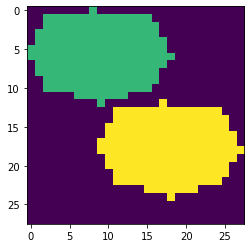

In [20]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [21]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    
    root = 'data'
    mask_folder = 'output'
    mask = list([])
    for file in data_df['json']:
        
        _, _, scene, img_name = file.split('/')
        img_name = img_name[:-5]
        
        w, h, labels, vertexlist = get_poly(file)

        img = Image.new("RGB", (w,h))
        img2 = ImageDraw.Draw(img)

        for i,j in zip(labels, vertexlist):
            if len(j)<2:
                continue
            img2.polygon(j, fill=label_clr[i])
            

        img = np.array(img)
        im = Image.fromarray(img[:,:,0])
        
        if not os.path.exists(os.path.join(root,mask_folder,scene)):
            os.makedirs(os.path.join(root,mask_folder,scene))
            
        path = str(os.path.join(root,mask_folder,scene,img_name+'.png'))
        im.save(path)
        mask.append(path)
        
    data_df['mask'] = mask
    
    return data_df

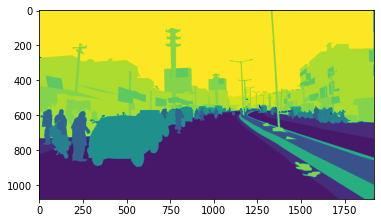

In [22]:
w, h, labels, vertexlist = get_poly('data/mask/201/frame0029_gtFine_polygons.json')

img = Image.new("RGB", (w,h))
img2 = ImageDraw.Draw(img)

for i,j in zip(labels, vertexlist):

    img2.polygon(j, fill=label_clr[i])

img=np.array(img)

im = Image.fromarray(img[:,:,0])

plt.imshow(img[:,:,0])


im.save("test_image.png")

In [23]:
data_df = compute_masks(data_df)
data_df.head()

,image,json,mask
0,data/images/224/frame1127_leftImg8bit.jpg,data/mask/224/frame1127_gtFine_polygons.json,data/output/224/frame1127_gtFine_polygons.png
1,data/images/224/frame1365_leftImg8bit.jpg,data/mask/224/frame1365_gtFine_polygons.json,data/output/224/frame1365_gtFine_polygons.png
2,data/images/224/frame1796_leftImg8bit.jpg,data/mask/224/frame1796_gtFine_polygons.json,data/output/224/frame1796_gtFine_polygons.png
3,data/images/224/frame2227_leftImg8bit.jpg,data/mask/224/frame2227_gtFine_polygons.json,data/output/224/frame2227_gtFine_polygons.png
4,data/images/224/frame2452_leftImg8bit.jpg,data/mask/224/frame2452_gtFine_polygons.json,data/output/224/frame2452_gtFine_polygons.png


True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


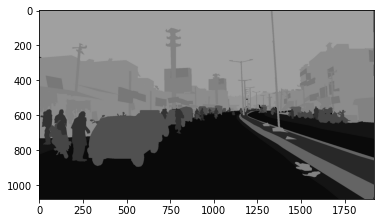

In [24]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [25]:
data_df = pd.read_csv('preprocessed_data.csv')

In [26]:
X_data = data_df['image']
Y_data = data_df['mask']

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

1) Formulation
Dice loss = 1 - sum(Y_true*Y_pred)/sum(Y_true**2 + Y_pred**2)

2) Range =  0 (perfect overlap) to 1 (no overlap)

3) It is inspired from Dice coefficient which is A.intersection(B)/ A.Union(B).
   The numerator is concerned with the common activations between our prediction and target mask, where as the denominator is concerned with the quantity of activations in each mask separately.
   
4) Since, it is computed for each class separately I think classes with smallest occureces are also paid attention.



In [27]:
pip install -U segmentation-models

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [28]:
import imgaug.augmenters as iaa

In [29]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
from keras.callbacks import Callback, LearningRateScheduler, TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# sm.set_framework('tf.keras')
tensorflow.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [30]:
sm.__version__

'1.0.1'

In [31]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [32]:
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [33]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [34]:
# def visualize(**images):
#     n = len(images)
#     plt.figure(figsize=(16, 5))
#     for i, (name, image) in enumerate(images.items()):
#         plt.subplot(1, n, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.title(' '.join(name.split('_')).title())
#         if i==1:
#             plt.imshow(image, cmap='gray', vmax=1, vmin=0)
#         else:
#             plt.imshow(image)
#     plt.show()
    
# def normalize_image(mask):
#     mask = mask/255
#     return mask

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, image_paths, mask_paths, w, h, dataset_type):
        
        
        self.images_fps   = [i for i in image_paths]
        # the paths of segmentation images
        self.masks_fps    = [i for i in mask_paths]
        # giving labels for each class
        self.class_values = list(set(self.label_clr.values()))
        # image width
        self.w = 512
        # image height
        self.h = 512
        # dataset is train or test
        self.dataset_type = dataset_type
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(image_mask,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.dataset_type == 'train':
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
   
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
    
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=42)

In [36]:
train_dataset = Dataset(X_train, y_train, w, h, 'train')
test_dataset  = Dataset(X_test, y_test, w, h, 'test')


train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)

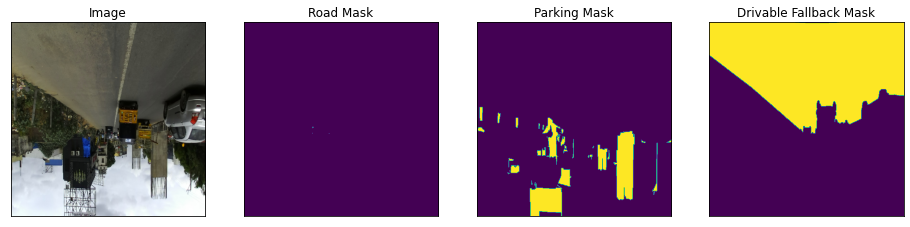

In [37]:
image, mask = train_dataset[4]

visualize(
    image=image, 
    road_mask=mask[..., 0].squeeze(),
    parking_mask=mask[..., 1].squeeze(),
    drivable_fallback_mask=mask[..., 2].squeeze(),
)

In [38]:
import keras 
import datetime

In [39]:
model1 = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(512,512,3))
optim = keras.optimizers.Adam(learning_rate=0.0001)
focal_loss = sm.losses.cce_dice_loss
model1.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

85524480/85521592 [==============================] - 4s 0us/step


In [40]:
print(image.shape, mask.shape)

(512, 512, 3) (512, 512, 21)


In [41]:

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    ModelCheckpoint('./best_model_Unet.h5', save_weights_only=True, save_best_only=True, \
                                       mode='max', monitor='val_iou_score'),
    ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
    EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1),
    TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
]

In [42]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tensorflow.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [43]:
history = model1.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10, validation_data=test_dataloader, callbacks=callbacks)

Epoch 1/10
450/450 [==============================] - 495s 1s/step - loss: 0.8770 - iou_score: 0.3763 - val_loss: 0.7974 - val_iou_score: 0.4396
Epoch 2/10
450/450 [==============================] - 485s 1s/step - loss: 0.7070 - iou_score: 0.5036 - val_loss: 0.6710 - val_iou_score: 0.5077
Epoch 3/10
450/450 [==============================] - 467s 1s/step - loss: 0.6044 - iou_score: 0.5838 - val_loss: 0.5629 - val_iou_score: 0.5846
Epoch 4/10
450/450 [==============================] - 462s 1s/step - loss: 0.5458 - iou_score: 0.6331 - val_loss: 0.5361 - val_iou_score: 0.6028
Epoch 5/10
450/450 [==============================] - 463s 1s/step - loss: 0.5420 - iou_score: 0.6381 - val_loss: 0.5325 - val_iou_score: 0.6099
Epoch 6/10
450/450 [==============================] - 469s 1s/step - loss: 0.5306 - iou_score: 0.6524 - val_loss: 0.5310 - val_iou_score: 0.6110
Epoch 7/10
450/450 [==============================] - 468s 1s/step - loss: 0.5279 - iou_score: 0.6552 - val_loss: 0.5293 - val_iou

In [44]:
model1.load_weights('best_model_Unet.h5')

In [45]:
scores = model1.evaluate_generator(test_dataloader)
metrics=[sm.metrics.IOUScore(threshold=0.5)]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.5301
mean iou_score: 0.61182


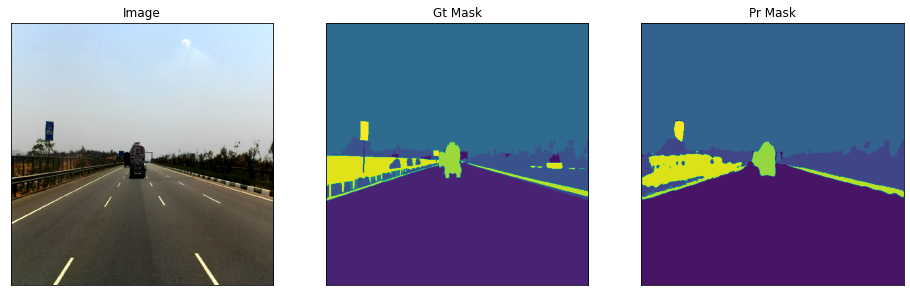

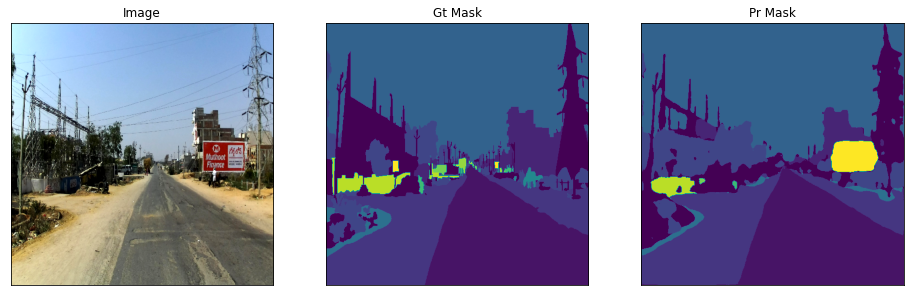

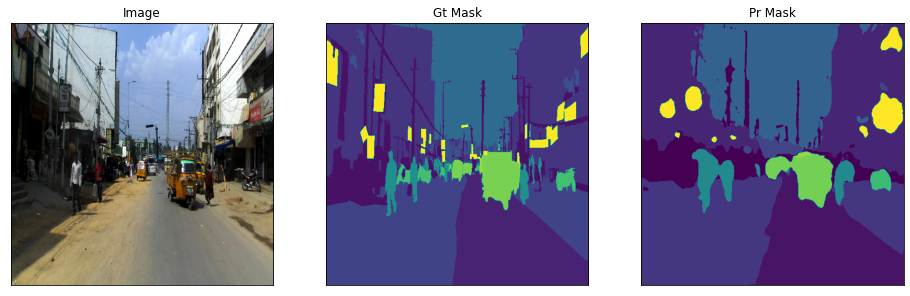

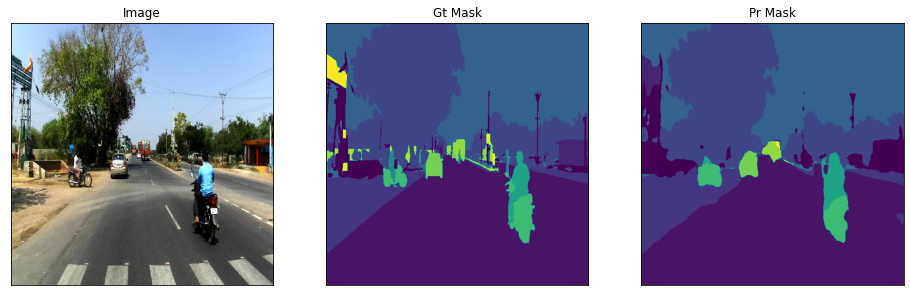

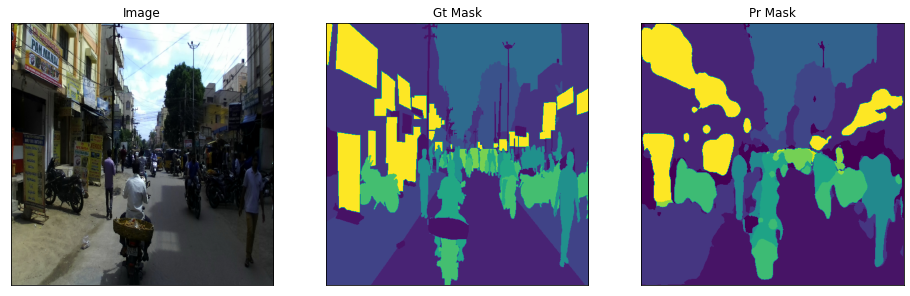

In [46]:

n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, actual_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    prediction = model1.predict(image)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction, axis = 0)
    actual_mask = np.argmax(actual_mask, axis=-1)

    visualize(image=denormalize(image.squeeze()), gt_mask=actual_mask.squeeze(),pr_mask=prediction.squeeze())

# Task 3: Training CANet

In [47]:
import tensorflow
# tf.compat.v1.enable_eager_execution()
# from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [48]:
class convolutional_block(tensorflow.keras.layers.Layer):
    def __init__(self, kernel=3, filters=[4,4,8], stride=4, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.block_name = name
        
    def build(self, data):
        self.cov1 = Conv2D(filters=self.F1, kernel_size=(1,1), strides=(1, 1), padding='valid', name = self.block_name+'_CONV1', dtype='float32')
        self.cov2 = Conv2D(filters=self.F2, kernel_size=(self.kernel,self.kernel), strides=(self.stride, self.stride), padding='same', name = self.block_name+'_CONV2', dtype='float32')
        self.cov3 = Conv2D(filters=self.F3, kernel_size=(1,1), strides=(1, 1), padding='valid', name = self.block_name+'_CONV3', dtype='float32')
        self.cov4 = Conv2D(filters=self.F3, kernel_size=(self.kernel,self.kernel), strides=(self.stride, self.stride), padding='same', name = self.block_name+'_SIDE_CONV1', dtype='float32')
        self.bn1 = BatchNormalization(axis=-1)
        self.bn2 = BatchNormalization(axis=-1)
        self.bn3 = BatchNormalization(axis=-1)
        self.bn4 = BatchNormalization(axis=-1)
        self.relu1 = Activation('relu')
        self.relu2 = Activation('relu')
        self.relu3 = Activation('relu')
        self.relu4 = Activation('relu')
        self.add = Add()
 
    def call(self, data):
        # write the architecutre that was mentioned above
        
        X = self.cov1(data)
        X = self.bn1(X)
        X = self.relu1(X)
        
        X = self.cov2(X)
        X = self.bn2(X)
        X = self.relu2(X)
        
        X = self.cov3(X)
        X = self.bn3(X)
        X = self.relu3(X)
        
        Y = self.cov4(data)
        Y = self.bn4(Y)
        Y = self.relu4(Y)
        
        output = self.add([X,Y])
        
        return output

In [49]:
A = convolutional_block(name = "C1_conv_block", kernel=3, filters=[4,4,8], stride=2)(np.zeros((3,256,256,3)))
A.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([3, 128, 128, 8])

In [50]:
class identity_block(tensorflow.keras.layers.Layer):
    
    def __init__(self, name="identity block", kernel=3,  filters=[4,4,8], stride=1):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.block_name = name

    def build(self,shapes):
        self.cov1 = Conv2D(filters=self.F1, kernel_size=(1,1), strides=(1, 1), padding='valid', name = self.block_name+'_CONV1', dtype='float32')
        self.cov2 = Conv2D(filters=self.F2, kernel_size=(3,3), strides=(1, 1), padding='same', name = self.block_name+'_CONV2', dtype='float32')
        self.cov3 = Conv2D(filters=self.F3, kernel_size=(1,1), strides=(1, 1), padding='same', name = self.block_name+'_CONV3', dtype='float32')
        self.bn1 = BatchNormalization(axis=-1)
        self.bn2 = BatchNormalization(axis=-1)
        self.bn3 = BatchNormalization(axis=-1)
        self.actv1 = Activation('relu')
        self.actv2 = Activation('relu')
        self.actv3 = Activation('relu')
        
        self.add = Add()

    def call(self, data):
        # write the architecutre that was mentioned above
        
        X = self.cov1(data)
        X = self.bn1(X)
        X = self.actv1(X)
        
        X = self.cov2(X)
        X = self.bn2(X)
        X = self.actv2(X)
        
        X = self.cov3(X)
        X = self.bn3(X)
        X = self.actv3(X)
        
        output = self.add([X,data])
        
        return output

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [51]:
class global_flow(tensorflow.keras.layers.Layer):
    def __init__(self, name="global_flow", filters=32):
        super().__init__(name=name)
        self.filters = filters

    def build(self, shapes):
        
        # here data is a TensorShape
        self.avgpool = AveragePooling2D(1,(shapes[1],shapes[1]),data_format='channels_last')
        self.bn = BatchNormalization(axis=-1)
        self.actv = Activation('relu')
        self.cov = Conv2D(filters=32, kernel_size=(1,1), strides=(1, 1), padding='valid', name = self.name+'_CONV1', dtype='float32')
        self.upsample = UpSampling2D(size=(shapes[1],shapes[1]), data_format='channels_last', interpolation='bilinear')

    def call(self, data):
        # implement the global flow operation
        
        X = self.avgpool(data)
        X = self.bn(X)
        X = self.actv(X)
        X = self.cov(X)  
        X = self.upsample(X)
        
        #print(X.shape)
        return X

In [52]:
class context_flow(tensorflow.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

    def build(self, shapes):
        
        self.avgpool = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='valid', data_format='channels_last')
        self.concat = Concatenate(axis = -1)
        self.cov1 = Conv2D(filters=shapes[1][-1], kernel_size=(3,3), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.cov2 = Conv2D(filters=shapes[1][-1], kernel_size=(3,3), strides=(1, 1), padding='same', name = self.name+'_CONV2', dtype='float32')
        self.cov3 = Conv2D(filters=shapes[1][-1], kernel_size=(1,1), strides=(1, 1), padding='same', name = self.name+'SIDE_CONV1', dtype='float32')
        self.cov4 = Conv2D(filters=shapes[1][-1], kernel_size=(1,1), strides=(1, 1), padding='same', name = self.name+'SIDE_CONV2', dtype='float32')
        self.relu = Activation('relu')
        self.sigmoid = Activation('sigmoid')
        self.multiply = Multiply()
        self.add = Add()
        self.upsample = UpSampling2D(size=(2,2), data_format='channels_last', interpolation='bilinear')

    def call(self, data):
        # here X will a list of two elements 
        INP, FLOW = data[0], data[1] 
        # implement the context flow as mentioned in the above cell
        
        X = self.concat([INP,FLOW])
        X = self.avgpool(X)
        X = self.cov1(X)
        X = self.cov2(X)
        
        
        Y = self.cov3(X)
        Y = self.relu(Y)
        Y = self.cov4(Y)
        Y = self.sigmoid(Y)
        
        
        Z = self.multiply([X,Y])
        
        Z = self.add([X,Z])
        
        output = self.upsample(Z)
        #print(output.shape)
        return output

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [53]:
class fsm(tensorflow.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)

    def build(self, shapes):

        self.cov1 = Conv2D(filters=shapes[-1], kernel_size=(3,3), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.cov2 = Conv2D(filters=32, kernel_size=(1,1), strides=(1, 1), padding='valid', name = self.name+'_CONV1', dtype='float32')
        self.globalAvgPool = GlobalAveragePooling2D(data_format='channels_last')
        self.bn = BatchNormalization(axis=-1)
        self.sigmoid = Activation('sigmoid')
        self.multiply = Multiply()
        self.upsampl = UpSampling2D(size=(2,2), data_format='channels_last', interpolation='bilinear')

    def call(self, data):
        # implement the FSM modules based on image in the above cells
        
        
        X = self.cov1(data)
        
        X = self.globalAvgPool(X)
        
        X = tensorflow.reshape(X,shape=(-1,1,1,X.shape[1]))

        X = self.cov2(X)
        
        X = self.bn(X)
        
        X = self.sigmoid(X)
        
        output = self.multiply([data,X])
        
        FSM_Conv_T = self.upsampl(output)
        
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [54]:
class agcn(tensorflow.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)

    def build(self, shapes):
        self.cov1 = Conv2D(filters=shapes[-1], kernel_size=(7,1), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.cov2 = Conv2D(filters=shapes[-1], kernel_size=(1,7), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.cov3 = Conv2D(filters=shapes[-1], kernel_size=(1,7), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.cov4 = Conv2D(filters=shapes[-1], kernel_size=(7,1), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.cov5 = Conv2D(filters=shapes[-1], kernel_size=(3,3), strides=(1, 1), padding='same', name = self.name+'_CONV1', dtype='float32')
        self.add = Add()


    def call(self, data):
        # please implement the above mentioned architecture
        # print(data.shape)
        
        X = self.cov1(data)
        X = self.cov2(X)
        # print(X.shape)
        
        Y = self.cov3(data)
        Y = self.cov4(Y)
         #print(Y.shape)
        
        Z = self.add([X,Y])
        output = self.cov5(Z)
        
        output = self.add([Z,output])
        
        return output

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [55]:
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

# write the complete architecutre


C1 = convolutional_block(name = "C1_conv_block", kernel=3, filters=[4,4,8], stride=2)(X)
TO_AGCN = C1
# print('C1')
# print(X.shape)
# print('-'*50)
C1 = identity_block(name = "C1_id_block1", kernel=3, filters=[4,4,8], stride=1)(C1)
C1 = identity_block(name = "C1_id_block2", kernel=3, filters=[4,4,8], stride=1)(C1)
# print(X.shape)

# print('\nC2')
# C2 and ID2
C2 =convolutional_block(name = "C2_conv_block", kernel=3, filters=[8,8,16], stride=2)(C1)
# print(X.shape)
# print('-'*50)
C2 = identity_block(name = "C2_id_block1", kernel=3, filters=[8,8,16], stride=1)(C2)
C2 = identity_block(name = "C2_id_block2", kernel=3, filters=[8,8,16], stride=1)(C2)
C2 = identity_block(name = "C2_id_block3", kernel=3, filters=[8,8,16], stride=1)(C2)

# print(X.shape)

# print('\nC3')
# C3 ad ID3
C3 =convolutional_block(name = "C3_conv_block", kernel=3, filters=[16,16,32], stride=1)(C2)
# print(X.shape)
# print('-'*50)
C3 = identity_block(name = "C3_id_block1", kernel=3, filters=[16,16,32], stride=1)(C3)
C3 = identity_block(name = "C3_id_block2", kernel=3, filters=[16,16,32], stride=1)(C3)
C3 = identity_block(name = "C3_id_block3", kernel=3, filters=[16,16,32], stride=1)(C3)
C3 = identity_block(name = "C3_id_block4", kernel=3, filters=[16,16,32], stride=1)(C3)
C3 = identity_block(name = "C3_id_block5", kernel=3, filters=[16,16,32], stride=1)(C3)
#C3 = identity_block(name = "C3_id_block7", kernel=3, filters=[16,16,32], stride=1)(C3)
# print(X.shape)

# print('\nC4')
# C4 and ID4
C4 = convolutional_block(name = "C4_conv_block4", kernel=3, filters=[32,32,64], stride=1)(C3)
# print(X.shape)
# print('-'*50)
C4 = identity_block(name = "C4_id_block1", kernel=3, filters=[32,32,64], stride=1)(C4)
C4 = identity_block(name = "C4_id_block2", kernel=3, filters=[32,32,64], stride=1)(C4)
# C4 = identity_block(name = "C4_id_block3", kernel=3, filters=[32,32,64], stride=1)(C4)
# C4 = identity_block(name = "C4_id_block4", kernel=3, filters=[32,32,64], stride=1)(C4)


print('C4 shape ',C4.shape)

GF = global_flow(name = 'global_flow', filters = 32)(C4)
print('GF shape ',GF.shape)

CF1 = context_flow(name = 'context_flow1')((C4,GF))
CF2 = context_flow(name = 'context_flow2')((C4,CF1))
CF3 = context_flow(name = 'context_flow3')((C4,CF2))

SUM = Add()([GF, CF1, CF2, CF3])
print('SUM shape ',SUM.shape)


FSM_Conv_T = fsm()(SUM)
print('FSM_Conv_T shape', FSM_Conv_T.shape)

AGCN_op = agcn()(TO_AGCN)
print('AGCN_op shape',AGCN_op.shape)

final_op = Concatenate(axis = -1)([FSM_Conv_T, AGCN_op])

final_op = Conv2D(filters=21, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', name = 'OP_CONV2', dtype='float32')(final_op)

final_op  = UpSampling2D(size=(4,4), data_format='channels_last', name='OP_UP_SAMPL', interpolation='bilinear')(final_op)

final_op = Activation('softmax')(final_op)


model = Model(inputs = X_input, outputs = final_op)

model.summary()

C4 shape  (None, 64, 64, 64)
GF shape  (None, 64, 64, 32)
SUM shape  (None, 64, 64, 32)
FSM_Conv_T shape (None, 128, 128, 32)
AGCN_op shape (None, 128, 128, 8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_4 (Activation)       (

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [56]:
def modify_lr_rate(epoch, lr):
    '''
        this function modifies learning rate
    '''
        
    if (epoch+1)%3 == 0: # REDUCE ACCURACY BY 10% IF EPOCH IS MULTIPLE OF 3
        lr = lr/10
        print('lr decreased :{} '.format(lr))
        return lr
        
    return lr

In [57]:
lrschedule = LearningRateScheduler(modify_lr_rate)

In [58]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
    ModelCheckpoint('./best_model_Canet.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
]

In [59]:
optim = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optimizer = optim, loss=focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

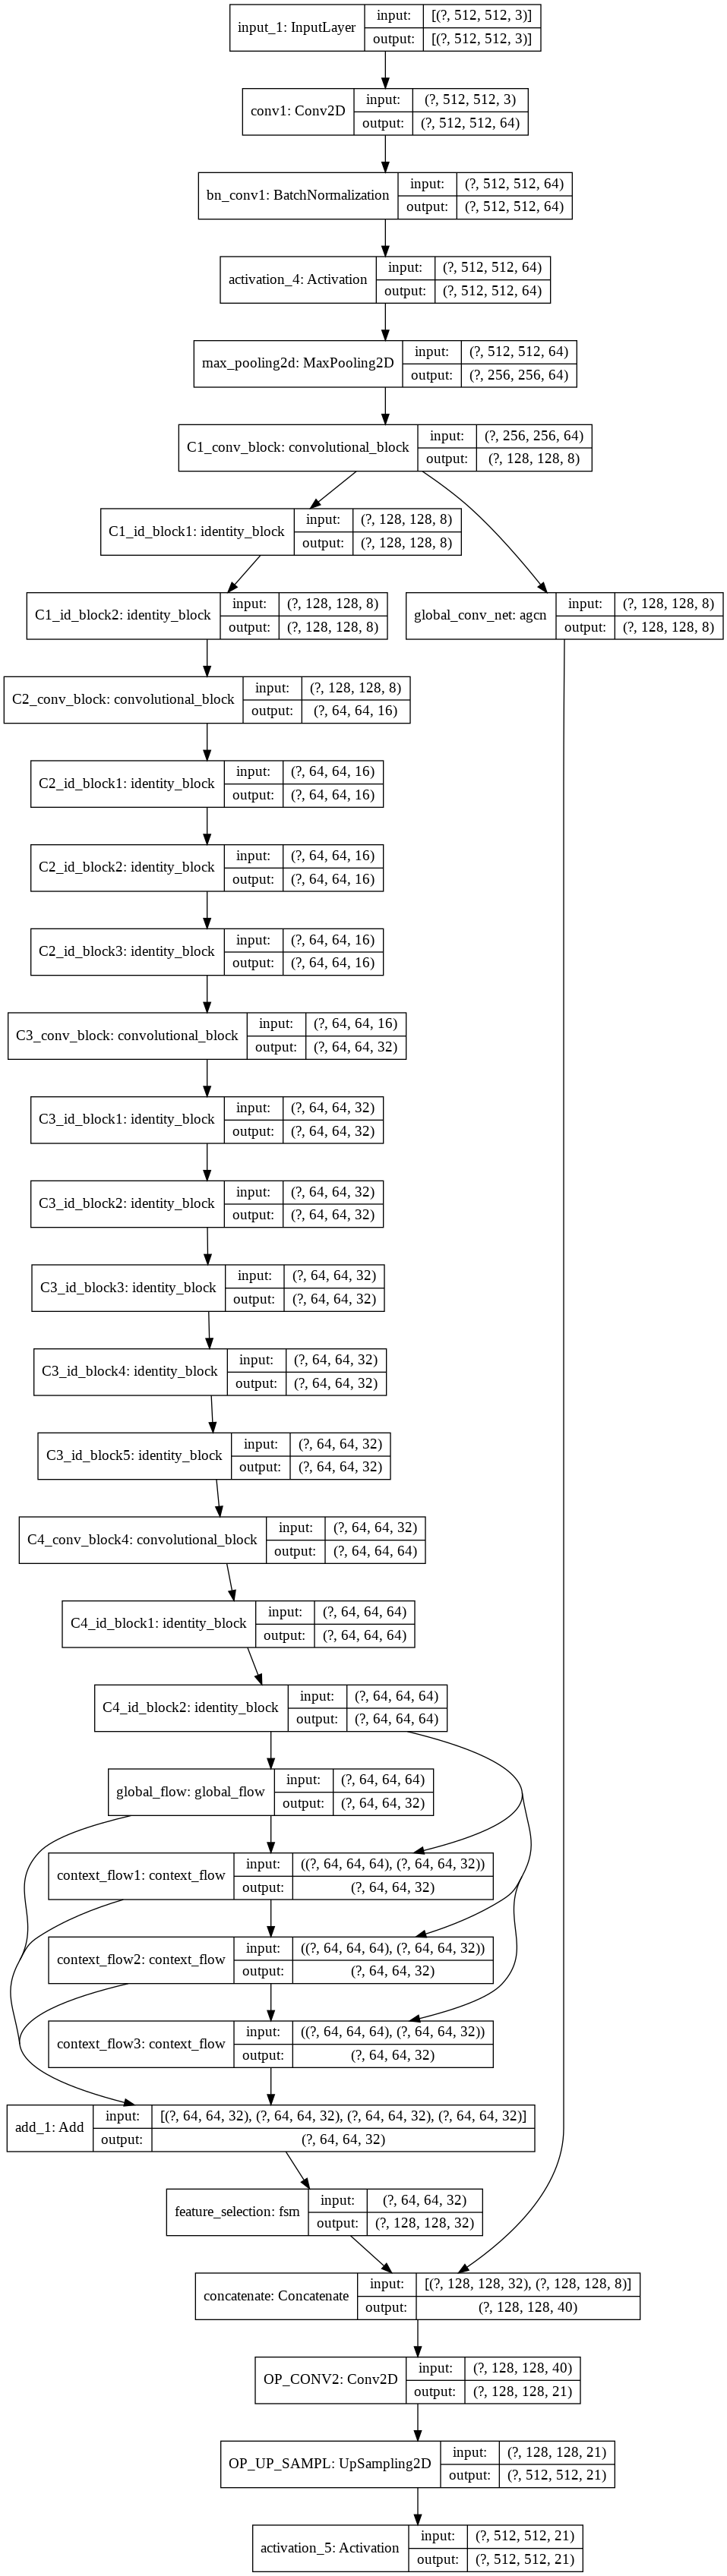

In [60]:
tensorflow.keras.utils.plot_model(model, to_file='caNet.png', show_shapes=True)

In [61]:
history = model.fit_generator(train_dataloader, steps_per_epoch = len(train_dataloader), epochs=10, validation_data=test_dataloader, callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
450/450 [==============================] - 507s 1s/step - loss: 0.9823 - iou_score: 0.1881 - val_loss: 0.9441 - val_iou_score: 0.2683
Epoch 2/10
450/450 [==============================] - 509s 1s/step - loss: 0.9181 - iou_score: 0.2949 - val_loss: 0.9022 - val_iou_score: 0.3207
Epoch 3/10
450/450 [==============================] - 494s 1s/step - loss: 0.8952 - iou_score: 0.3235 - val_loss: 0.8888 - val_iou_score: 0.3243
Epoch 4/10
450/450 [==============================] - 493s 1s/step - loss: 0.8736 - iou_score: 0.3379 - val_loss: 0.8637 - val_iou_score: 0.3429
Epoch 5/10
450/450 [==============================] - 494s 1s/step - loss: 0.8542 - iou_score: 0.3551 - val_loss: 0.8470 - val_iou_score: 0.3507
Epoch 6/10
450/450 [==============================] - 496s 1s/step - loss: 0.8400 - iou_score: 0.3667 - val_loss: 0.8373 - val_iou_score: 0.3618
Epoch 7/10
450/450 [==============================] - 

In [64]:
model.load_weights('best_model_Canet.h5')

Instructions for updating:
Please use Model.evaluate, which supports generators.
Loss: 0.94414
mean iou_score: 0.26825


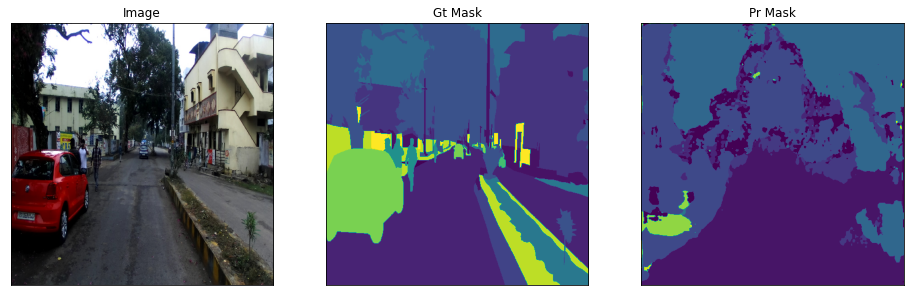

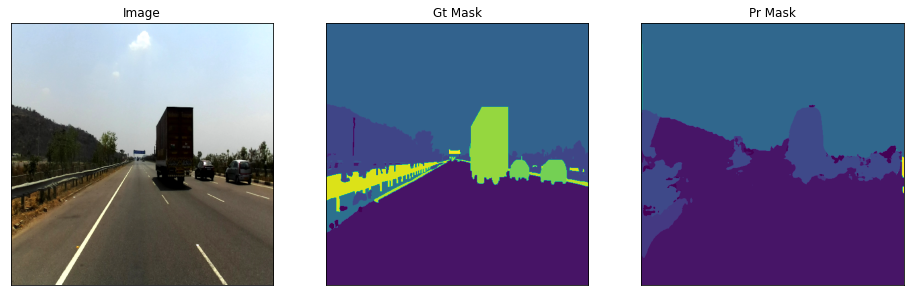

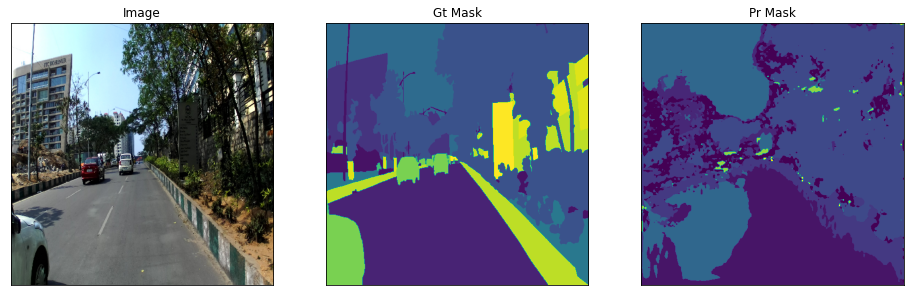

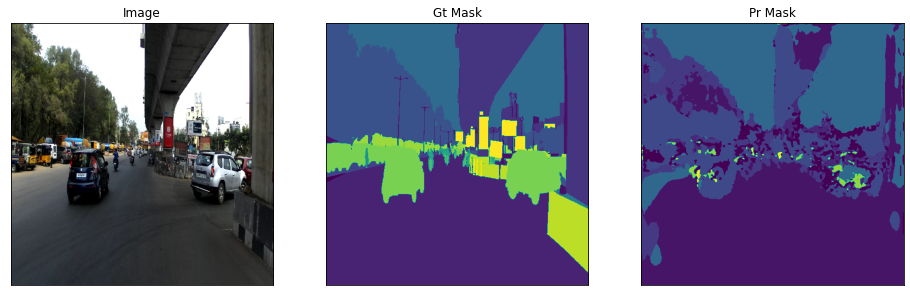

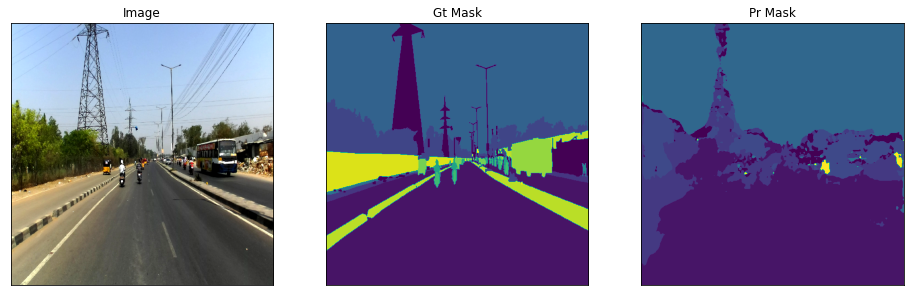

In [65]:
scores = model.evaluate_generator(test_dataloader)
metrics=[sm.metrics.IOUScore(threshold=0.5)]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))


n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, actual_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.squeeze(prediction, axis = 0)
    actual_mask = np.argmax(actual_mask, axis=-1)

    visualize(image=denormalize(image.squeeze()), gt_mask=actual_mask.squeeze(),pr_mask=prediction.squeeze())


### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations